OSE Scientific Computing | Winter 2021, M.Sc. in Economics, University of Bonn | [Sona Verdiyeva](https://github.com/s6soverd) and [Abraham Raju](https://github.com/Abraham-newbie)

# Prediction of Crime Rates using Brightness derived from Nighttime Satellite Light Images - VIIRS

This notebook contains derivation of brightness index from [VIIRS Nighttime Satellite Light Images](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG), and with the addition of other control variables, the prediction of crime rates in the city of Portland, Oregano state in US. As far as the brightness index concerns, the index is derived for all the neighborhoods in the city of Portland, for which the 'offense type and occurrence' datasets are available. 

### Table of Contents 
* [1.Overview](#overview) 
* [2.VIIRS - Nighttime Satellite Light Images](#viirs) 
* [3.On the derivation of Brightness Index](#derivation) 
    * [3.1. Example: Manual Derivation](#manuald)
    * [3.2. Unit Test on Brightness Index function](#unittest)
* [4. Preparation of the data for further analysis](#datawrangling)
* [5. Interactive Mapping: Crime Data and Brightness Values across Years](#mapping)
* [6. Random Forest Regression: Prediction of crime rate using Brightness Index](#rfc)
* [7.Conclusion](#conclusion)
* [8.References](#references)


In [1]:
#### All the neccessary Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame, Image
import datetime as dt
### Functions imported from the auxiliary file
import auxiliary.data_wrangling as dw
#import auxiliary.brightness as br
#import auxiliary.geo_converter as gc
#import auxiliary.maps as maps
###Loading in necessary packages
#Reading in the data
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px

import os
import calplot #pip
import datetime
import openpyxl
import statsmodels.formula.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from pandas.plotting import andrews_curves
import geopandas
#conda install -c conda-forge utm
import sklearn
import shapely
import folium
from folium.plugins import FastMarkerCluster
from geopandas.tools import sjoin
#from shapely.geometry import Point, Polygon
#import geoplot as gplty
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame, GeoSeries
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydot

import auxiliary.crime_data_cleaning as c_c
import auxiliary.descriptive_plots as d_p
import auxiliary.analysis as a_y




## Background 

Our research objective  draws from extensive literature involving analysis of geo-spatial crime data especially examining the relationship between crime and night lights.
The question according to ,the words of Lee Ross and Richard Nesbitt, “the person versus the situation?” (Crime Lab New York - https://urbanlabs.uchicago.edu/projects/crime-lights-study)


A large literature suggestis that small changes to the environment, for example 'the broken window'theory, can affect human behaviour. This principle is shown in many studies including Stanley Milgram's classic obedience studies and also in many policy-relevant applications which involves 'nudges'.
Previous studies have looked at specifically the effect of night-time lighting on crime.


A 2015 study published in the Journal of Epidemiology and Community Health found that streetlights don’t prevent accidents or crime, but do cost a lot of money. The researchers looked at data on road traffic collisions and crime in 62 local authorities in England and Wales and found that lighting had no effect, whether authorities had turned them off completely, dimmed them, turned them off at certain hours, or substituted low-power LED lamps.


According to a 2011 study of London street lighting and crime, there is no good evidence that increased lighting reduces total crime.” A 1997 National Institute of Justice study concluded, “We can have very little confidence that improved lighting prevents crime.”

Bad outdoor lighting can even decrease safety by making victims and property easier to see. A Chicago Alley Lighting Project showed a correlation between brightly lit alleyways and increased crime. (https://www.darksky.org/light-pollution/lighting-crime-and-safety/)

## Research Objective

## Is there a effect of night lighting on crime, and if so, what kind of crimes?

Our research objective is to combine the night-light information from NOAA night lights for every individual county of Portland across time with crime data from the Portland Police Department

This allows us look at a simple model which firstly predicts crimes using brightness data, but also exploit the heterogenity between counties in portland to answer the question of whether nightlighting actually does affect crime, or if the differences in crime rates are almost entirely controlled by poverty.

First,the substantial geographic concentration of crime, particularly violent crime, suggests that the social and physical features of the urban landscape might potentially play an important role in the crime production function (Weisburd 2015). Inequality has been indicated to be the most significant driver of crime, however the question of whether a small difference in crime could be explained purely by night-lighting.This can be due to extra visibility provided to pedestrians and the implict understanding that police may be present.

## 1. Overview <a class="anchor" id="overview"></a>

Spatial Analysis of crime is the use of Geospatial Information to visualize the spatial data for explanatory statistical analysis and as well as with the purpose of identifying how certain factors (e.g, population characteristics, structural or ecological changes etc.) affect the spatial patterns of crime.  Crime mapping, hence, can be used for resource allocation and policy improvement purposes, so that the police force has a more centralized knowledge of the hotspots of different crime types across time and space and the concerns of the local populace are better addressed. <br>
In *'Crime Prediction & Monitoring Framework Based on Spatial Analysis'*, the authors put an emphasis on analysis of past crime data in helping to predict the crime rate, which could in turn, assist in reducing the crime rate(Hitesh Kumar Reddy et al., 2018). The underlying rationale is that crimes are predictable since the offenders operate under their comfort zones, and once a crime is committed, the same offense could be repeated under similar settings/circumstances.  And since there is a possibility of the same offense to happen again, this makes it easier to predict crime. The authors utilize K-Nearest neighbors and Naive Bayes algorithm and a dataset with latitude, longitude of a location where offence took place and the monthly frequency of the different types of offenses for the given row of latitude and longitude data. The past dataset is taken as a training dataset and the recent dataset is used as testset. If in the past a certain crime type occurred in a certain latitude-longitude point, K-NN calculates the Manhattan distance of trainset and testset geospatial datapoints, and the probability of this crime happening again, and the locations nearby the previous crime location is set to be more probable for the crime occurrence. <br>
In *'Crime Rate Inference with Big Data'*, the inference of crime rate at the neighborhood level is undertaken using not only geospatial and demographic data but also taxi flow data in the city of Chicago(Hongjian Wang, 2016). To do the inference, both linear and Poisson regression models are used, as in predicting the crime rate, there is no guarantee that the predicted crime rate would be non-integer, hence Poission model is also used for the same problem. <br>
A large number of studies suggest that there is a link between crime rate and the socioeconomic and demographic characteristics. In one study in Portland, it was established that how intensive the crime rate in surrounding areas is affects the level of crime in the bordering neighborhoods (Kadziolka, 2016). The spatial weight matrix was derived using the below formula, where $w_{ij} = 1$ if $i \neq j$,where area $i$ shares a common border with area $j$. Otherwise, $w_{ij} = 0$.
$$
w^{*}_{ij} = \frac{w_{ij}}{\sum\limits_{j} w_{ij}}
$$
Crime is a phenomenon that is associated with socioeconomic and psychological factors. But whether it is random across space and time, hinting at the unimportance of geography is the central topic of the *'Exploratory spatial analysis of crimes
against property in Turkey'*, and the conclusion that the authors have reached is that the property offenses are densely concentrated in the west and south-western parts of Turkey, meaning, crime is not random across time and space (S. Erdogan, 2012). <br>
This project focuses on the addition of brightness values derived from Nighttime Satellite Image Collection in predicting the number of crime occurrences that are more bound to happen during the night, and see whether the lights do hold a predictive power over crime occurrence or not. <br>
The structure of the notebook is as follows. The first section explains the VIIRS - Nighttime Satellite Light Images, followed by how the brightness values across time given an area of interest is derived. All the functions are placed in their corresponding files in auxiliary folder. Since Continuous Integration was failing in installing neccessary packages (geopandas, geemap, ee, os, folium, fiona), the certain functions are commented out; however, their outputs are saved. <br>
To run this notebook with uncommented functions, one could create a local environment by running the below commands in the command line of shell:
```python
! conda create --name geo
! conda activate geo
! conda install mamba –c conda –forge     #Instaling mamba, that makes the installation of ‘geemap’ package faster
! mamba install geemap –c conda –forge
! conda install –c anaconda ipykernel
! conda config --prepend channels conda-forge
! conda create -n geo --strict-channel-priority geopandas jupyterlab  #Installing geopandas on Windows
! python –m ipykernel install --user --name = geo   #This sets this conda environment on your jupyter notebook
```
The follow-up subsection displays an example derivation for a given latitude-longitude point, the output of which is plotted against time. The unit test is written for testing couple of features of the brightness function. <br>
In the subsequent section, the data is prepared for the further analysis, by concatenating the crime datasets across years and matching the names of neighborhoods inside crime dataset with those in brightness index dataframe. Since brightness index dataframe is based on a shapefile of neighborhoods and their corresponding geometry information and crime datasets are sourced from a different website, there were differences in how the names of the same neighborhood was written. After the names were matched, the datasets were merged and saved into three different files, whether the crime occurred during the daytime, or nighttime, or all day long. <br>
The interactive mapping section explores the geospatial analysis of crime patterns against the distribution of brightness and population by neighborhoods in Portland. <br>
The section on Random Forest Regression explores the predictive power of brightness values in predicting the crime occurrence number, and compares the accuracy metric of the model against that of the rudimentary baseline model.






## 2. VIIRS - Nighttime Satellite Light Images <a class="anchor" id="viirs"></a>

The first digital archive of nighttime lights taken by satellites established at the National Geophysical Data Center in 1992 contains nighttime data from two satelitte platforms - United States Air Force series of polar-orbiting Defense Meteorological Satellite Program-Operational Linescan System (DMSP-OLS) and the current NASA/NOAA SNPP satellite’s the Visible Infrared Imaging Radiometer Suite (VIIRS-DNB) (Xi Chen et al., 2019).  <br>
The first low-light imagery from DMSP dates back to 1960's, while the dataset availability for VIIRS-DNB covers the period from 2014-01-01 onwards. Some new features of VIIRS lights data have eliminated or reduced the limitations of DMSP-OLS sensor. In a nutshell, the main limitations of DMSP-OLS sensor are the following (Feng-Chi Hsu et al., 2015):
* Low radiometric resolution
* No on-board calibration
* Large spatial resolution
* Saturation in urban cores <br>

To process the satellite imagery, we will be using **Google Earth Engine (GEE)**, which is a cloud-based platform for planetary-scale geospatial analysis. It is open and free to the public. In addition, GEE provides access to multiple remotel-sensed datasets, including VIIRS-DNB. To pull VIIRS-DNB nighttime light images from GEE, the eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used. <br>
For interactive mapping with GEE, **geemap** -a python package - is used, as it is not part of the standard Python library, it should be seperately downloaded and installed. Geemap can be used to analyse and visualize datasets available in GEE. <br>
To work with satellite data that covers enormous area geospatially, one can work with smaller Area of Interest, that can be either a buffer zone around a latitude-longitude point or a geometry from geopolitical boundary; and then the entire image dataset is clipped into this smaller AOI. <br>
If one wants to focus on the geopolitical boundary of a country, then a **shapefile** of the country is used. Shapefile  is a digital vector storage format for storing the geographic location. Geographic features in a shapefile can be represented by points, lines, or polygons (areas).  <br>
To import shapefile with geemap, the **Coordinate Reference System (CRS)** of the shapefile should be EPSG:4326. CRS basically tells Python how the coordinates inside a shapefile relates to places on Earth. 

## 3.On the derivation of Brightness Index <a class="anchor" id="derivation"></a>

The function below is generic enough to work with VIIRS-DNB image collection for any time period available and for any AOI (either buffer zone or shapefile). The daily images in VIIRS-DNB are aggregated into **monthly composites**, so given a point on Earth and a year, there are only 12 images in the collection. 

Since we are going to work with shapefile of the city, we need to provide the path to the shapefile, rather than the shapefile itself. Because to import the shapefile with geemap, a path to your shapefile should be given. And the directory in which your .shp (shapefile) is located should also include .dbf, .cpg, .prj, .shx extension files that comes with a usual shapefile folder. <br>
To read the content of the shapefile, **geemap** package is being used, which only accepts the shapefile with the CRS format being equal to **"EPSG:4326"**.  The brightness.py file inside auxiliary folder comes with a function to identify the crs of the shapefile. Unless the CRS of a shapefile is equal to **"EPSG:4326"**, the brightness function will set the CRS to the accepted format. <br>
To get to know how to use the brightness function and access the explanation of the arguments used, one can use the function below to access the docstrings:

In [2]:
def explanation(function):
    return print(function.__doc__)
#explanation(function = br.brightness)

**Step 1:** <br>
Extracting the image collection for the years specified and the given band from the VIIRS-DNB Nighttime satellite light images, we use **ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(date_from, date_to).select(band)** Earth Engine snippet. VIIRS Image Collection is available overall for the years: 2014-01-01 - 2021-05-01. **NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG** is simply the complete dataset. For the Dataset - VIIRS Stray-light Corrected Day/Night Band composites, there are two bands available: 
* avg_rad(=Average DNB radiance values.) 
* cf_cvg (=Cloud-free coverages, This band can be used to identify areas with low numbers of observations 
     where the quality is reduced.) 

**Step 2:** <br>
First we need to create a list of feautures for all areas of interest in the form of **ee.Feature(ee.Geometry.Point(latitude, longitude).buffer(km), dict)** if buffer zone and latitute and longitude points are provided; or **ee.Feature(imported_shapefile.geometry(), dict)** if the shapefile is being fed into the function. Here, 'geometry' is the column with the geospatial data, since the usual shapefiles come with the geospatial data being stored in the 'geometry' column.  <br>
Specifically, a Feature is an object with a geometry property storing a Geometry object (or null) and a properties property storing a dictionary of other properties.

**Step 3:** <br>
Given the list of features, we are going to create a Feature Collection for our areas of interest using **ee.FeautureCollection(features)**.

**Step 4:** <br>
The function to reduce our collection of geometries to a single parameter, in our case, to the arithmetic mean of its inputs (pixel values) per a monthly aggregate satellite image and also another function to get the individual image dates. And we map these functions to our image collection.

**Step 5:** <br>
We create a reducer that collects its inputs into a list, using earth engine objects for mean values from images and the dates. 

In [3]:
### Below, we will first dentify the crs of the shapefile, and derive the the brightness index for the shapefile of Portland

#path_to_my_shapefile = r".\Shapefile_Portland\Neighborhood_Boundaries.shp"
#crs_portland_shp = br.identify_crs(pathtomyshapefile = path_to_my_shapefile)
#brightness_index = br.brightness(date_from = "2015-07-01", date_to = "2021-05-31", 
                           #  buffer_df = None, buffer_dist = None, band = "avg_rad", aoi_type = "shapefile", 
                           #  crs = crs_portland_shp.upper(), pathtomyshapefile = path_to_my_shapefile,
                           #  shp_column_name = "NAME")
#brightness_index.to_csv("data/brightness_index.csv")
brightness_index = pd.read_csv("data/brightness_index.csv")

### 3.2. Example: Manual Derivation <a class="anchor" id="manuald"></a>

Let's do a simple derivation of brightness index for a latitude and longitude point of Ganja, a city in the northwest of Azerbaijan, for the Jan 2015 to April 2021, and plot the values across dates "2015-01-01" to '2021-04-01'. <br>
**Step 1:** <br>
Given the fact that VIIRS-DNB Image Collection has only one image per month, we need to have two seperate lists of dates in date format; in one list, the first days of the months from 2015 January till April 2021 are included, and in the other, the last days of the month, using [pd.date_range](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html) function and [datetime.date](https://docs.python.org/3/library/datetime.html) module in python. <br>
**Step 2:** <br>
The eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used for the dates Jan 2015 to April 2021. <br>
And the whole image collection for each month seperately is being then clipped into the area of interest being demarcated by **ee.Geometry.Point([lon, lat]).buffer(km)** function. <br>
**Step 3:** <br>
The area of interest is then being reduced to the average brightness value per month for the pixels in Ganja, using [image.reduceRegion(reducer, scale)](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion) function. <br>
**Step 4:** <br>
Lastly, we cast the derived value to  [ee.Number(numeric_object).getInfo()](https://developers.google.com/earth-engine/apidocs/ee-number-getinfo) and get the number of the computed object.

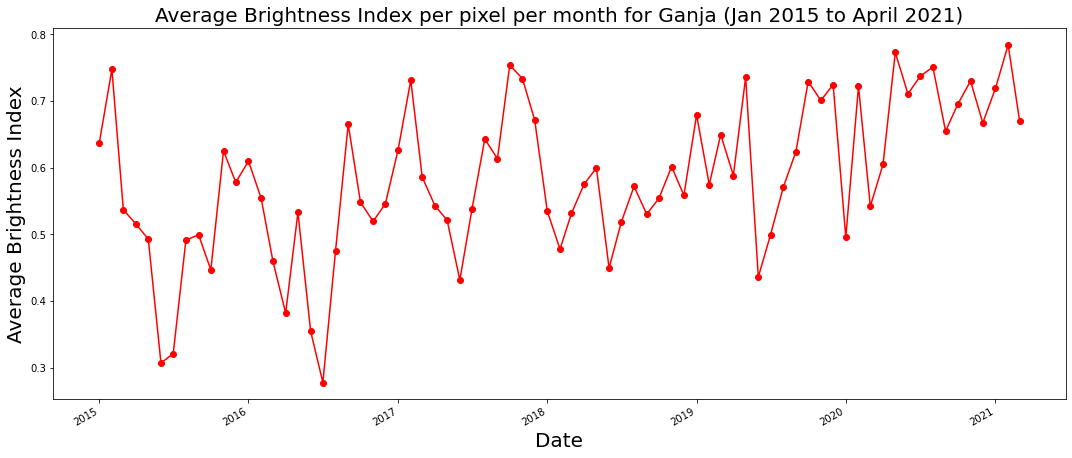

In [4]:
#ganja = br.ganja_brightness(date_from = '2015-01-01', date_to = '2021-04-01', 
                           # ganja_lat = 40.6879, ganja_lon = 46.3723, buffer_distance = 50000)
#ganja.to_csv("data/ganja_brightness.csv")
ganja = pd.read_csv("data/ganja_brightness.csv")
first_day_of_month= pd.date_range('2015-01-01', '2021-04-01', freq='1M') - pd.offsets.MonthBegin(1)
df_date_first_days = pd.DataFrame(data = first_day_of_month, columns = ["first_day_dates"])
f = df_date_first_days["first_day_dates"].dt.date
fig, ax = plt.subplots(figsize=(15,7))
plt.plot_date(f, ganja["ganja_brightness"], linestyle = 'solid', color = 'r')
ax.set_ylabel('Average Brightness Index',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Average Brightness Index per pixel per month for Ganja (Jan 2015 to April 2021)',fontsize=20)
plt.tight_layout()
plt.gcf().autofmt_xdate()

### 3.2. Unit Test on Brightness Index function <a class="anchor" id="unittest"></a>

A **Unit Test** is a small test that checks at a time whether a single component in an application/function/etc. works in the expected way. There are many test runners in Python, the one that is built into standard Python library is called **unittest**, which you need to simply import, for it to run the test. To write and execute your test in unittest, there are some requirements:
* ```Python
import unittest
```
* Put your tests into classes as methods, for that one needs to create a subclass, that inherits from unittest TestCase class
* Add *self* as the first and only argument for test functions
* Instead of built-in assert statement, use self.assertEqual(), self.assertIs(), self.assertTrue(), self.assertIn(),etc. methods of the TestCase Class. 
* To run the test in shell, there are different command line entries; e.g., <br>

This one executes your test file:
```Python
python <'the name of the test file goes here'> 
```

This one executes your test file and -v (verbose) option lists the names of the functions and the result of each:
```Python
python -m unittest -v <'the name of the test file goes here'>
```  

In [5]:
# ! python -m unittest -v test_brightness

## 3. Portland Crime Data Analysis


The Portland Police Bureau was among the many law enforcement agencies which were selected to be a part of the National Crime Statistics Exchange. This program was desgined to compile a national sample of incident-based crime data using the National Incident Based Reporting System. 
The National Incident Based Reporting System was implemented to improve the overall quality of crime data which was collected by law enforcement which greatly expanded the uniformity requirement of crime occurences. This information includes information on victims, known offenders, relationships between victims and offenders, arrestees, as well as property invovled in crimes.

Though the data reported by the UCR Program's traditional summary reporting program existed prior to this, the NIBRS goes much deeper because of the ability to provicde details on on separate offenses within the same incident—including information on victims, known offenders, relationships between victims and offenders, arrestees, and property involved in crimes.


The data used for this analysis can be found here https://www.portlandoregon.gov/police/71978.

The data is detailed, capturing every crime occurence, the type of crime, the category and neighborhood of occurence.

In [6]:
files = os.listdir("data")
prefix='CrimeData-'
file_list= list(filter(lambda file: file.startswith(prefix),files))
clean_data=c_c.clean_data(file=file_list) 
clean_data.head()

data/CrimeData-2015.csv
data/CrimeData-2016.csv
data/CrimeData-2017.csv
data/CrimeData-2018.csv
data/CrimeData-2019.csv
data/CrimeData-2020.csv
data/CrimeData-2021.csv


,CaseNumber,Neighborhood,OccurDate,OccurTime,OffenseCategory,OffenseCount,OccurMonth_Year
912,15-X4331944,Brentwood-Darlington,2015-07-01,138,Assault Offenses,1,2015-07
918,15-X4332622,Lloyd,2015-07-01,1230,Assault Offenses,1,2015-07
919,15-X4332748,Humboldt,2015-07-01,1315,Assault Offenses,1,2015-07
920,15-X4332811,Centennial,2015-07-01,1746,Assault Offenses,2,2015-07
921,15-X4332836,Hazelwood,2015-07-01,2134,Assault Offenses,1,2015-07


The data includes variables like: 


**Date** - Date the incident occurred. The exact occur date is sometimes unknown. In most situations, the first possible date the crime could have occurred is used as the occur date. (For example, victims return home from a week-long vacation to find their home burglarized. The burglary could have occurred at any point during the week. The first date of their vacation would be listed as the occur date.)

**Time** - Time the incident occured. The exact occur time is sometimes unknown. In most situations, the first possible time the crime could have occured is used as the occur time.
The time is reported in the 24-hour clock format, with the first two digits representing hour (ranges from 00 to 23) and the second two digits representing minutes (ranges from 00 to 59).
Note: By default, Microsoft Excel removes leading zeroes when importing data. For more help with this issue, refer to Microsoft's help page.

**Address** - Address of reported incident at the 100 block level (e.g.: 1111 SW 2nd Ave would be 1100 Block SW 2nd Ave).
To protect the identity of victims and other privacy concerns, the address location of certain case types are not released.

**Open Data Lat / Lon** - Found to be missing in all cases

**Neighborhood** - Neighborhood where incident occurred.
If the neighborhood name is missing, the incident occurred outside of the boundaries of the Portland neighborhoods or at a location that could not be assigned to a specific address in the system (e.g., Portland, near Washington Park, on the streetcar, etc.). Note: Neighborhood boundaries and designations vary slightly from those found on the Office of Community & Civic Life website.


#### Crime Data Overview 

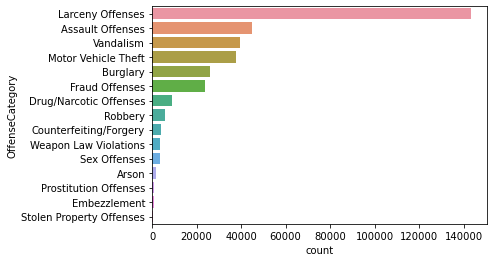

In [7]:
ax = sns.countplot(y="OffenseCategory",data=clean_data, order=clean_data.OffenseCategory.value_counts().iloc[:15].index)

Most of the data consists of Larceny Crimes while assault and Vandalism crimes still form a large part of the dataset. I.e, theft of propery and belongings form a significant chunk of the crime, which we also expect to be affected by night lighting.
Assault offences, which often occur in combination with offenses such as buglary, robbery and sex offenses, are also conventionally associated with 'occuring in the dark'.

## Historical Plot of Crime Data

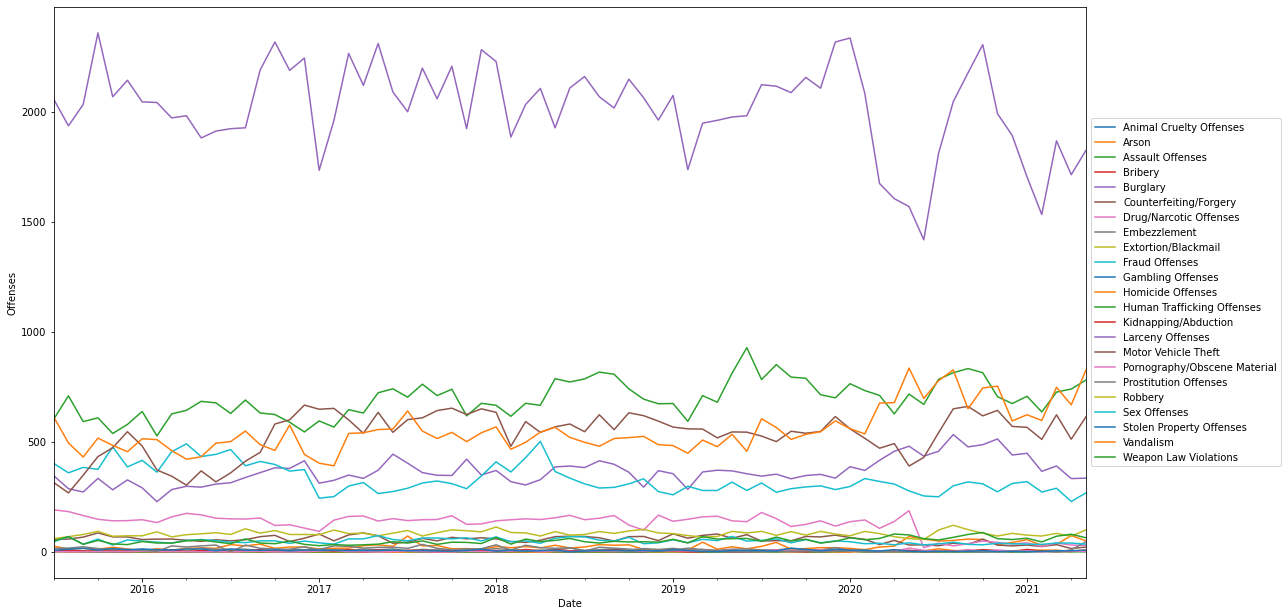

In [8]:
fig, ax = plt.subplots()

clean_data_crime=clean_data.groupby(['OccurMonth_Year','OffenseCategory']).OffenseCount.sum().reset_index()
for label, grp in clean_data_crime.groupby('OffenseCategory'):
    grp.plot(x = "OccurMonth_Year", y = "OffenseCount",ax = ax, label = label,)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.set_size_inches(18.5, 10.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Offenses')

### Time Distribution of Crimes in Portland

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x244.8 with 3 Axes>,
 array([<AxesSubplot:ylabel='2018'>, <AxesSubplot:ylabel='2019'>],
       dtype=object))

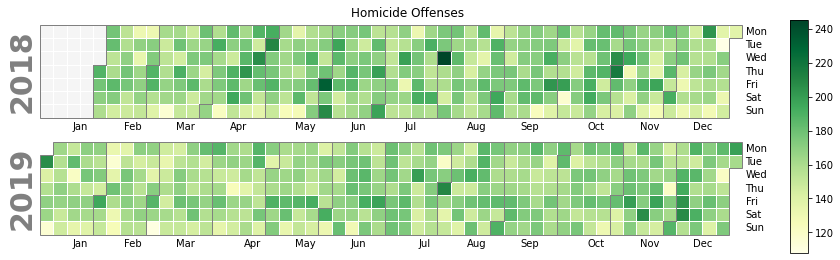

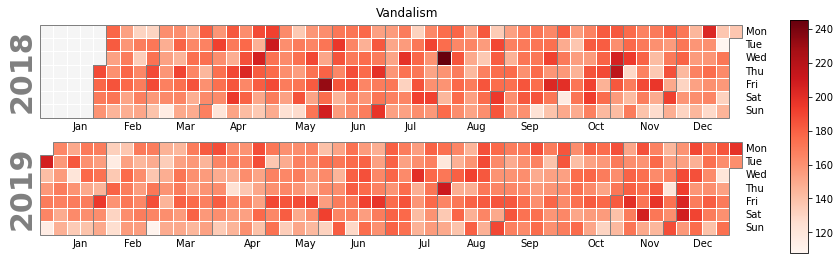

In [9]:
clean_data_calplot=clean_data.set_index('OccurDate')
clean_data_calplot= clean_data_calplot[clean_data_calplot.OccurMonth_Year>"2018-01-01"]
clean_data_calplot= clean_data_calplot[clean_data_calplot.OccurMonth_Year<"2020-01-01"]
clean_data_calplot_motor_theft= clean_data_calplot[clean_data_calplot.OffenseCategory=="Motor Vehicle Theft"]        
#calplot.calplot(clean_data_calplot['OffenseCount'])


clean_data_calplot_motor_theft= clean_data_calplot[clean_data_calplot.OffenseCategory=="Homicide Offenses"]       
calplot.calplot(clean_data_calplot['OffenseCount'], cmap='YlGn',suptitle="Homicide Offenses")


clean_data_calplot_vandalism= clean_data_calplot[clean_data_calplot.OffenseCategory=="Vandalism"]       
calplot.calplot(clean_data_calplot['OffenseCount'], cmap='Reds',suptitle="Vandalism")

There appears to be no directly visible correlation between months of occurence and crimes excluding the spike in crimes in December of Homicide and vandalism. This has been studied to be a common occurence historically in the United States.

### Graphing Night vs Day Crimes

As our project relies on analyzing the impact of night-time brightness on crime, we first need to examine the average crime-load across time. This can be analyzed by plotting crime spikes across time, for specific crime types and for all crimes seperately.

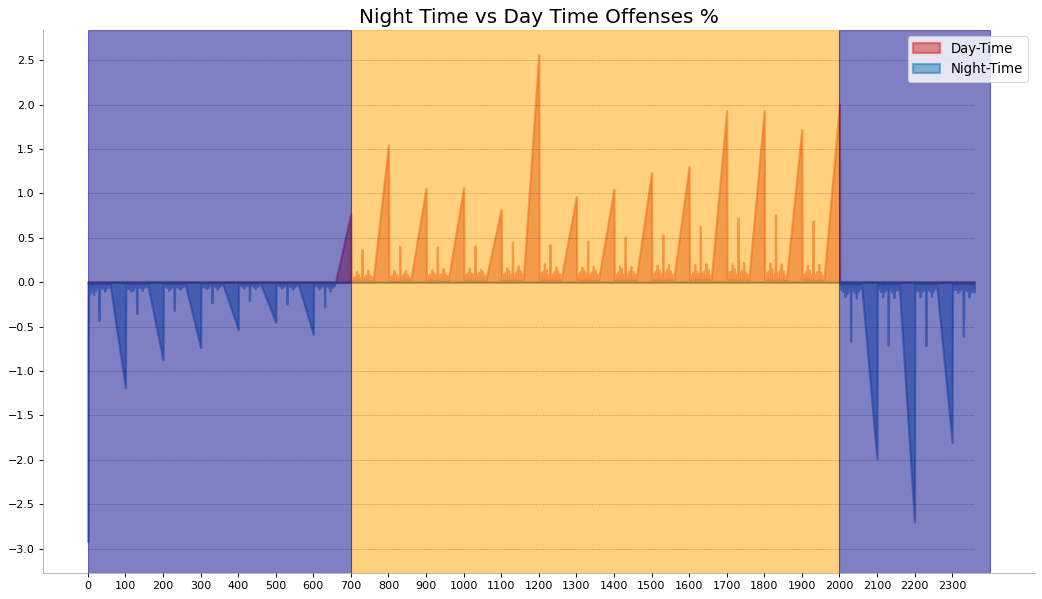

In [10]:
d_p.day_night_crimes(data=clean_data)

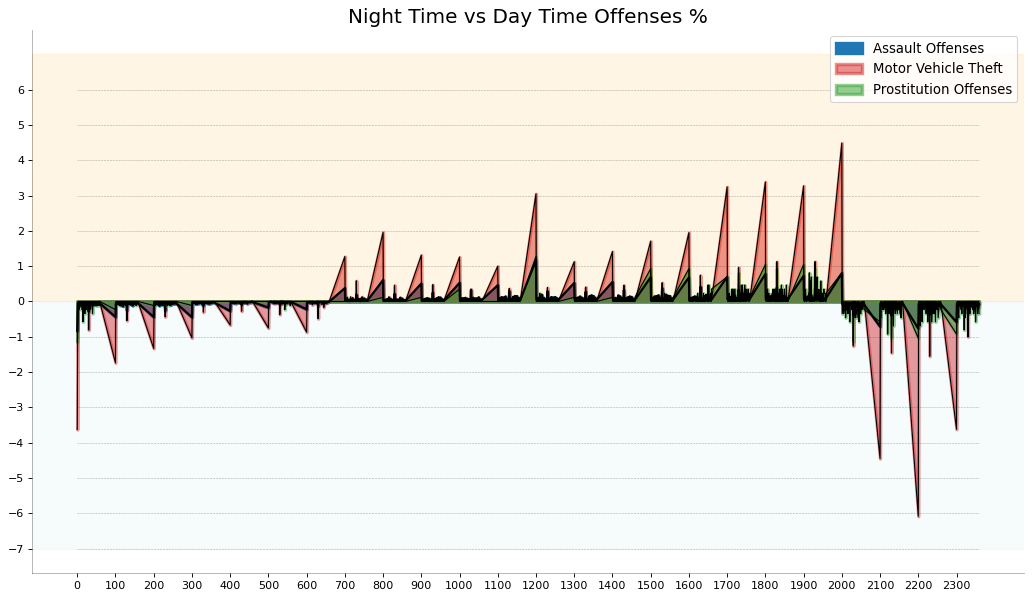

In [11]:
d_p.day_night_selected_crimes(data=clean_data)

[Section on peculiarity of data]

## 4. Introducing brightness and controls for heterogentity between counties <a class="anchor" id="datawrangling"></a>

Below, we are going to concat the crime data from 2015 to 2021 and match the names of the neighborhoods in Portland with the names of places in the shapefile for the brightness index. As it is a crime data for all the crime types that happened all day long, given the occurrence time, we divided the data for the crimes that happened during the day, night or all day long. For the prediction of the crime rate using brightness index, the crimes that occurred during the nighttime are relevant. 

In [12]:
# Crime Data for the years 2015 - 2021
df_matched1 = pd.read_csv("Crime_Data/CrimeData-2021.csv")
df_matched2 = pd.read_csv("Crime_Data/CrimeData-2020.csv")
df_matched3 = pd.read_csv("Crime_Data/CrimeData-2019.csv")
df_matched4 = pd.read_csv("Crime_Data/CrimeData-2018.csv")
df_matched5 = pd.read_csv("Crime_Data/CrimeData-2017.csv")
df_matched6 = pd.read_csv("Crime_Data/CrimeData-2016.csv")
df_matched7 = pd.read_csv("Crime_Data/CrimeData-2015.csv")

# Concat them all
dataframes = [df_matched1, df_matched2, df_matched3, df_matched4, df_matched5, df_matched6, df_matched7]
df_concatted = dw.drop_nan_and_uncommon_and_concat(dataframes = dataframes)

# Match and merge with brightness_index - for the Offenses that occurred in the night/ daytime/or both
df_matched = dw.matching_names(df1 = df_concatted, 
                               df2 = brightness_index, 
                               c1 = "Neighborhood", 
                               c2 = "Names of Places")
df_merged = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "night")
df_with_controls = dw.add_controls(df_merged = df_merged)

# Saving also the crime data with controls for daytime and for all daylong occurence
df_merged_day = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "day")
df_with_controls_day = dw.add_controls(df_merged = df_merged_day)

df_merged_all = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "all")
df_with_controls_all = dw.add_controls(df_merged = df_merged_all)


df_with_controls_day.to_csv("data/df_with_controls_daytime.csv")
df_with_controls_all.to_csv("data/df_with_controls_alldaylong.csv")
df_with_controls.to_csv("data/df_with_controls_nighttime.csv")

[@SONAL - please put above into a function]

To control for other neighborhood characteristics,we control for many other variables including:
    
**Real Estate** :
2017 data from the Regional Multiple Listing Service with analysis by the Center for Spatial Analysis and Research at Portland State University’s Department of Geography. Figures were rounded for legibility.

**People** :
Data from the US Census Bureau’s American Community Survey 5-Year Estimates, released December 2017. The ACS data are estimates only and accuracy varies by attribute.

**Rent Costs** :
Calculated from all renter-occupied units, estimated median rent is not adjusted for unit size or number of occupants. Figure includes estimated monthly utility costs.

**Median Income** :
The Census defines household as including “all the persons who occupy a housing unit as their usual place of residence.” Thus this estimate includes living situations ranging from individuals to large households.
    
**Transit** :
Portland 2017 data from TriMet. Suburban transit information was sourced from TriMet as well as other services, including CC Rider, C-TRAN, Canby Area Transit, Yamhill County Transit Area, and South Metro Area Regional Transit.

**Minutes by Car to Downtown** :
Google Maps estimate, based on non–rush hour conditions, from a neighborhood/suburb central point to Pioneer Courthouse Square.

**Walk Score** :
2017 data from Walkscore.com. This score reflects, on a scale of 1 to 100, a neighborhood’s pedestrian-friendliness based on distances to amenities such as grocery stores and other routine destinations.    

**People below federal poverty level** :
People below the federal poverty level as decided for the financial year.



**Unemployed (16 years or older)** :
Those unemployed for a majority of the year as %.


**Total Newcomers (%)** :
Percentage of newcomers in the city (i.e,migrants who move to work or live)

## 5. Interactive Mapping: Crime Data and Brightness Values across Years <a class="anchor" id="mapping"></a>

To generate interactive maps, a dataset should be extended with a geospatial data.

In [13]:
# Data Loading - shapefile of Neighborhoods in Portland in .csv format
shapefile_portland = pd.read_csv("data/shapefile_dataframe_format.csv")

### Exploratory Data Analysis
**1.** Bar Chart to visualize the population density data of Portland by neighborhood.

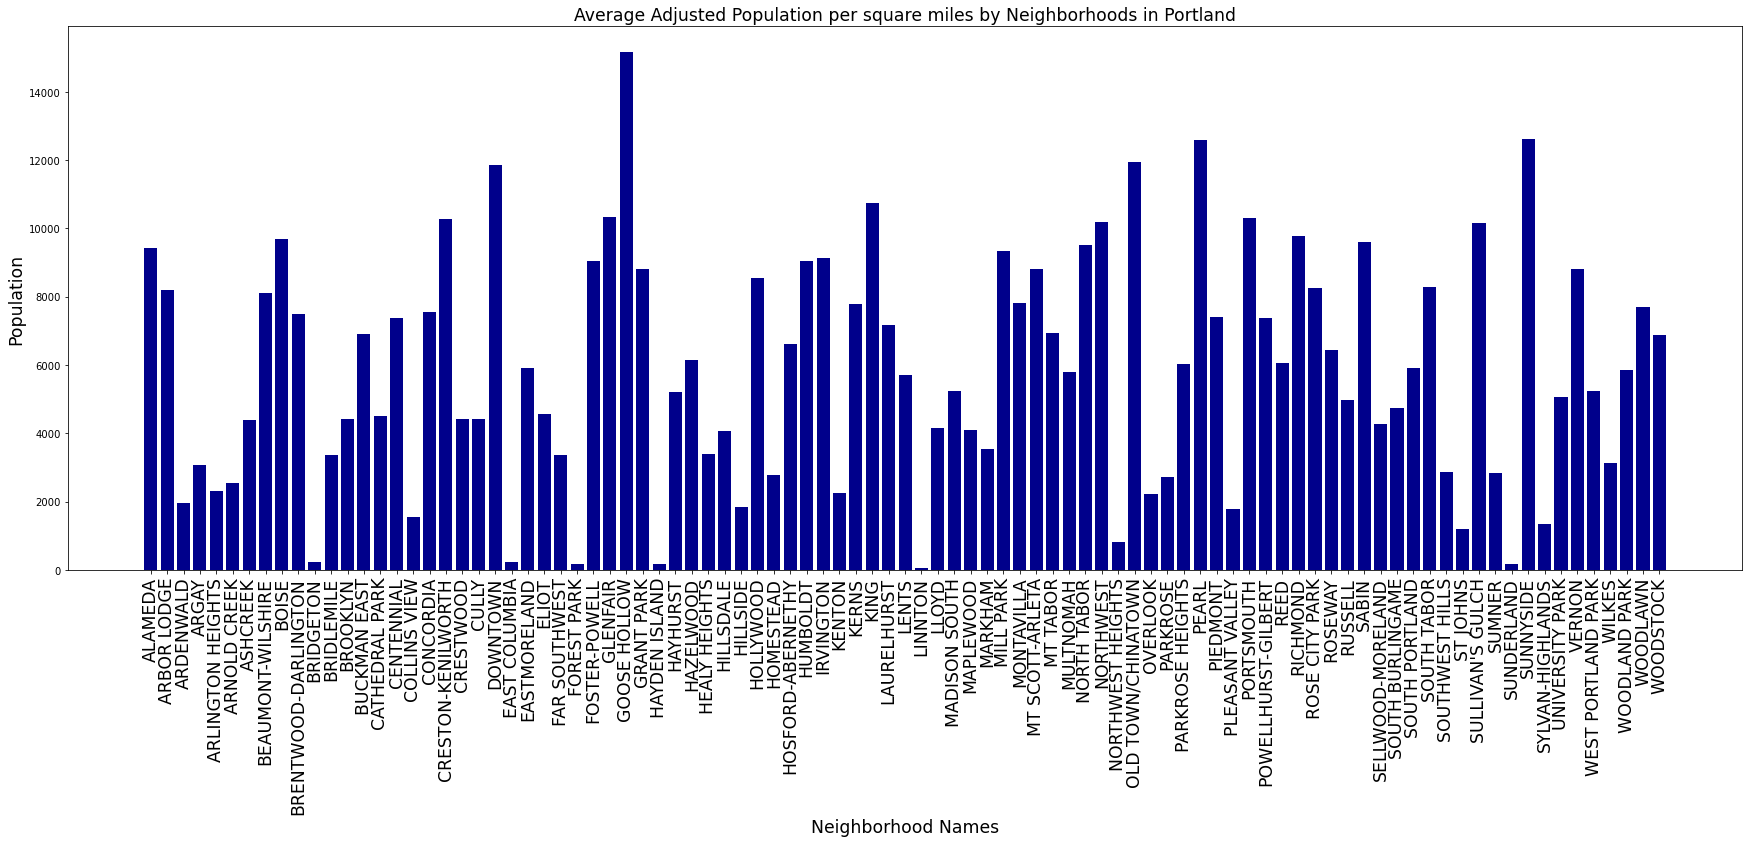

In [14]:
d_p.pop_graph(data=df_with_controls)

###  Choropleth Map using Shapefile
Let's now visualize choropleth maps for population density, crime data and brightness.

In [15]:
# Bringing the names of places in shapefile to the form that is used in crime dataset
list_names = []
for name in shapefile_portland["NAME"]:
    n = name.replace(" ", "_").replace("/", "_").replace(".", "").replace(",", "_")
    list_names.append(n)

# Creating a column to include the updated Names
shapefile_portland["Matched_Names"] = list_names

# Slicing the shapefile_portland dataframe to only include the Names and Geometry of the areas
sliced_shapefile = shapefile_portland[["Matched_Names", "geometry"]].dropna()

**1. Visualizing the population density:**

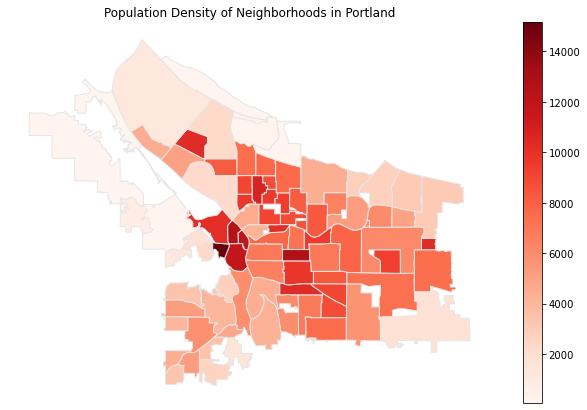

In [16]:
#maps.choropleth_by_pop(df_pop= df_with_controls, df_shapefile = sliced_shapefile, by = "interactive")
Image(filename='Figures/pop_density_static.png') 

From the static choropleth map above, it is apparent that the highest density of the population is spread across center and the south-eastern parts of the Portland. Let's see below, how the brightnes and the offense rate per $100000$ are spread and whether just by looking at the map, one could derive an apparent insight among them or not.

**2. Mapping By Brightness Index and year:**

In [17]:
# Generate annual average of brightness index by Neighborhoods in Portland
brightness_index["Year"] = brightness_index.dates.astype(str).str[:4]
brightness_annual_ave = brightness_index.groupby(["Names of Places",
                                                  "Year"])["Average Radiance Per Pixel Per month"].mean().reset_index()

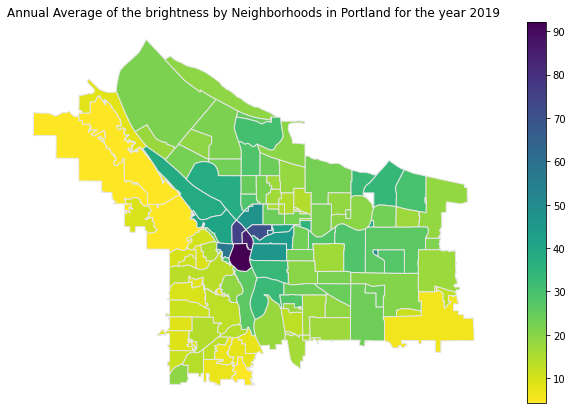

In [18]:
#maps.choropleth_by_brightness(df = brightness_annual_ave, shapefile = sliced_shapefile, 
                              #year = "2019", by = "static")
year = "2019"
Image(filename=f'Figures/Brightness_static{year}.png')

As it appears, the brightness values are higher in places where population is highly concentrated; mainly in the center and south-and-north-eastern parts of the map; which is to be expected.

**3. By Crime Rate and Year:**

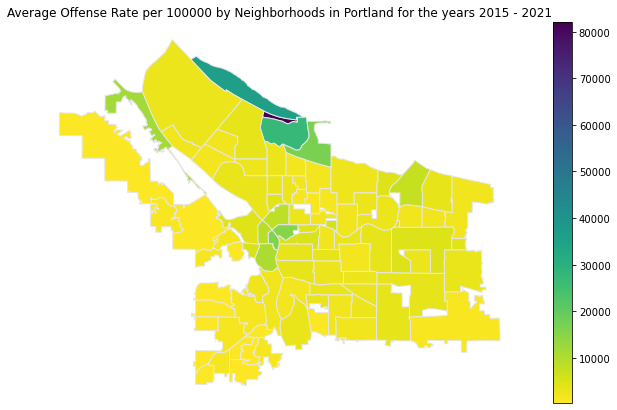

In [19]:
#maps.choropleth_by_crime(merged_df = df_with_controls, shapefile = sliced_shapefile,
                        #year = None, by = "interactive", type = "average")
Image(filename='Figures/AveCrimeRateper100k_static.png')   

The Offense rate per $100000$ is derived by summing up all types of offenses happened in a certain year and then dividing that value by the adjusted population number, which is then multiplied by $100000$ to get the rate. <br>
In the function, one has the option to set the aargument calle 'type' to average or yearly. If average is being chosen, as above,  average value for the offense rate per 100k across years is fed into the map. <br>
The average offense rate per 100k is high on the far north-west of the Portland, and it is distributed evenly low to other parts of the city. 


## 6. Random Forest Regression: Prediction of crime rate  using Brightness Index <a class="anchor" id="rfc"></a>

The problem we will tackle is the prediction of crime rate using brightness index, given 5 years of past crime and brightness data. The kind of prediction we will be delving into is a supervised Random Forest regression. It is supervised because we do have an access to the past data for both predictor and predicted variables. It is regression-based, since the variable we want to predict is continuous. <br>
The building block of Random Forest algorithm is **Decision Trees**. And to understand Random Forest, one needs to first understand what a decision tree is. In simplest terms, in order to arrive at a better estimate for a question, a series of questions are asked that narrow down the range of possible values for the estimate until we are confident enough about our prediction. And the decision tree, in simplest terms, is the flowchart of these questions that are connected to one another through branches emanating from each node denoted as True and False. The way decision tree learns is through training a model and given the past data and the true values to predict, it tries to map the inputs to outputs. <br>
However, the predictions based on a sole decision tree have variance. But what if we take hundreds or thousands of decision trees that are trained on random subset of the training set and average the prediction sets of them all, we will get the predictions that are closer to the true values. That is the fundamental idea behind **Random Forest**.

**1st Step: Import the required libraries**

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

**2nd Step: Prepare the data**

The offenses that are relevant for a prediction model using brightness index are 'Robbery', 'Prostitution Offenses', 'Larceny Offenses' and 'Sex Offenses'. So the label that we are going to predict will be the sum of the occurrence number per month for the above mentioned crimes in a neighborhood. The dataset is restricted to those neighborhoods for which there are entries ($0$ is also considered to be an observation) for each month across July, 2015 till 2021. <br>
For evaluating whether the choosing only relevant offenses for our label is indeed robust, we will also train our model on the dataset with total offenses being the label. 

**Relevant Offenses:**

In [21]:
# Read the data
df_rf = df_with_controls[['OccurMonth_Year', 'Matched_Names', 'Larceny Offenses', 'Prostitution Offenses', 'Robbery',
                          'Sex Offenses', 'Average Radiance Per Pixel Per month']] 

    

# Drop the rows with missing values
df_rf.dropna(inplace = True)
# Year and Month column being set as datetime
df_rf['OccurMonth_Year'] = pd.to_datetime(df_rf['OccurMonth_Year'], errors='coerce')
df_rf["Year"] = df_rf['OccurMonth_Year'].dt.year
df_rf["Month"] = df_rf['OccurMonth_Year'].dt.month
# neighborhoods having entries for each month from July, 2015 till 2021
names = []
for n in list(df_rf['Matched_Names'].unique()):
    if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2015)]) == 6:
        if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2016)]) == 12:
            if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2017)]) == 12:
                if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2018)]) == 12:
                    if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2019)]) == 12:
                        if len(df_rf[(df_rf['Matched_Names'] == n) & (df_rf["Year"] == 2020)]) == 12:
                            names.append(n)


df_rf = df_rf[df_rf['Matched_Names'].isin(names)]

# Summing up the occurrence number for the relevant offenses
df_rf["Offenses_Relevant"] = df_rf[['Prostitution Offenses', 'Robbery',
                                  'Sex Offenses', 'Larceny Offenses']].sum(axis = 1)

df_rf.drop(columns = ['Prostitution Offenses', 'Robbery', 'Sex Offenses', 'Larceny Offenses', 
                      'OccurMonth_Year'], inplace = True)

**Total Offenses:**

In [22]:
df_rf_total = df_with_controls[['OccurMonth_Year', 'Matched_Names', 'Total_Offenses',
                          'Average Radiance Per Pixel Per month']] 
# Drop the rows with missing values
df_rf_total.dropna(inplace = True)
# Year and Month column being set as datetime
df_rf_total['OccurMonth_Year'] = pd.to_datetime(df_rf_total['OccurMonth_Year'], errors='coerce')
df_rf_total["Year"] = df_rf_total['OccurMonth_Year'].dt.year
df_rf_total["Month"] = df_rf_total['OccurMonth_Year'].dt.month
df_rf_total = df_rf_total[df_rf_total['Matched_Names'].isin(names)]
df_rf_total.drop(columns = ['OccurMonth_Year'], inplace = True)


[@SONAL - please put above into a function]

For the ML model to understand the data, the names of neighborhoods inside "Neighborhood" column are converted to numerical representation; this is called 'one-hot encoding' of the data. 

In [23]:
# One-hot encoding the data in Matched_Names Column
df_rf_encoded = pd.get_dummies(df_rf)
df_rf_encoded.head()

,Average Radiance Per Pixel Per month,Year,Month,Offenses_Relevant,Matched_Names_ALAMEDA,Matched_Names_ARBOR_LODGE,Matched_Names_ARGAY_TERRACE,Matched_Names_BEAUMONT-WILSHIRE,Matched_Names_BOISE,Matched_Names_BRENTWOOD-DARLINGTON,...,Matched_Names_SULLIVAN'S_GULCH,Matched_Names_SUMNER_ASSOCIATION_OF_NEIGHBORS,Matched_Names_SUNDERLAND_ASSOCIATION_OF_NEIGHBORS,Matched_Names_SUNNYSIDE,Matched_Names_UNIVERSITY_PARK,Matched_Names_VERNON,Matched_Names_WEST_PORTLAND_PARK,Matched_Names_WILKES_COMMUNITY_GROUP,Matched_Names_WOODLAWN,Matched_Names_WOODSTOCK
0,15.004552,2015,7,1.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15.694406,2015,8,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.273379,2015,9,5.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13.110718,2015,10,5.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12.334072,2015,11,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Doing the one-hot-encoding for the dataset with **Total Offenses:**

In [24]:
df_rf_encoded_total = pd.get_dummies(df_rf_total)

**3rd Step: Train-Test Split**

We will convert the pandas object to numpy arrays as the algorithm arguments require them to be in array data type. To split the data into train and test set so as to evaluate the ML model against a baseline model, I splitted the entries from 2015 to 2019 into train set, and entries from 2020 into test set. The label to predict is "Offenses_Relevant" column. And the features that predict it are Averange Randiance values, Year, Month and the categorical variable - "Matched_Names".

In [25]:
train_features = np.array(df_rf_encoded[df_rf_encoded["Year"].isin([2015,
                                                                    2016,
                                                                    2017,
                                                                    2018, 
                                                                    2019])].drop("Offenses_Relevant",
                                                                                 axis = 1))

train_label = np.array(df_rf_encoded.loc[df_rf_encoded["Year"].isin([2015,
                                                                     2016,
                                                                     2017,
                                                                     2018,
                                                                     2019]), "Offenses_Relevant"])
test_features = np.array(df_rf_encoded[df_rf_encoded["Year"] == 2020].drop("Offenses_Relevant", axis = 1))
test_label = np.array(df_rf_encoded.loc[df_rf_encoded["Year"] == 2020, "Offenses_Relevant"])


The train-test split is done for the other dataset where Total Offenses as a column is the label.

In [26]:
train_features_t = np.array(df_rf_encoded_total[df_rf_encoded_total["Year"].isin([2015,
                                                                    2016,
                                                                    2017,
                                                                    2018, 
                                                                    2019])].drop("Total_Offenses",
                                                                                 axis = 1))

train_label_t = np.array(df_rf_encoded_total.loc[df_rf_encoded_total["Year"].isin([2015,
                                                                     2016,
                                                                     2017,
                                                                     2018,
                                                                     2019]), "Total_Offenses"])
test_features_t = np.array(df_rf_encoded_total[df_rf_encoded_total["Year"] == 2020].drop("Total_Offenses", axis = 1))
test_label_t = np.array(df_rf_encoded_total.loc[df_rf_encoded_total["Year"] == 2020, "Total_Offenses"])

**4th Step: Train our model**

We will initialize the model with 1000 decision trees and train the model on our train set.

Label being **"Relevant Offenses":**

In [27]:
#random_forest_model = RandomForestRegressor(n_estimators = 1000, random_state = 30)
random_forest_model = RandomForestRegressor()
random_forest_model.fit(train_features, 
                        train_label)

RandomForestRegressor()

Label being **"Total Offenses":**

In [28]:
random_forest_model_total_offenses = RandomForestRegressor()
random_forest_model_total_offenses.fit(train_features_t, 
                                       train_label_t)

RandomForestRegressor()

**5th Step: Establish the Baseline model**

A basline model uses simple summary statistics to create predictions for the dataset. This metric will be the one we will compare against the Random Forest algorithm. The chosen baseline model is to use past 5 years data and average it for a rough prediction in 2020. Meaning, if for the neighborhood Alameda in Portland, in the past 5 years, for the month, say, January, the average value for the relevant offenses is 5 so that would be the rough guess of the baseline model for the prediction in, say, January 2020. <br>
The baseline error will be calculated using the absolute value of the difference between **"baseline predictions"** and the test dataset label values, which are essentially the number of offenses relevant for the year 2020.


For **"Relative Offenses":**

In [29]:
# The Baseline Model
baseline_predictions = df_rf[df_rf["Year"].isin([2015, 2016, 
                                                2017, 2018, 
                                                2019])].groupby(["Month",
                                                                "Matched_Names"])["Offenses_Relevant"].mean().reset_index()

# Mean Baseline Error
baseline_errors = abs(baseline_predictions["Offenses_Relevant"] - test_label)
print('Mean baseline error: ', round(np.mean(baseline_errors), 2))

Mean baseline error:  8.7


For **"Total Offenses":**

In [30]:
# The Baseline Model
baseline_predictions_t = df_rf_total[df_rf_total["Year"].isin([2015, 2016, 
                                                2017, 2018, 
                                                2019])].groupby(["Month",
                                                                "Matched_Names"])["Total_Offenses"].mean().reset_index()

# Mean Baseline Error
baseline_errors_t = abs(baseline_predictions_t["Total_Offenses"] - test_label_t)
print('Mean baseline error: ', round(np.mean(baseline_errors_t), 2))

Mean baseline error:  21.79


**6th Step: Make predictions on the test set using the trained RF model and Evaluate the metric - Mean Absolute Error**

For evaluating the performance of the algorithm, Mean Absolute Error is chosen, instead of commonly used accuracy percentage, which is easier to interpret. The reason being is that in order to compute the accuracy percentage, one needs to divide the errors by the test labels. This means that there should be no zero observation in the dataset, otherwise, due to the division by zero error , it distorts getting meaningful accuracy percentage.

MAE for **"Relevant Offenses":**

In [31]:
# Using the trained model on the test data
predictions_rf = random_forest_model.predict(test_features)
# Compute the Mean Absolute Error 
errors_rf = abs(predictions_rf - test_label)
print('Mean Absolute Error is:', round(np.mean(errors_rf), 4))

Mean Absolute Error is: 3.7032


Our Random Forest Model beats the simple baseline Model, since $Mean Absolute Error = 3.8 < Mean Baseline Error = 8.7$.
When the dataset is cleaned of the observations for the Offenses_Relevant being zero and accuracy is calculated, accuracy equals to around 40-50%, which is rather low. However, this is expected, given the limitations of the dataset and the fact that the number of offenses are tried to be predicted using only brightness index.

MAE for **"Total Offenses":**

In [32]:
# Using the trained model on the test data
predictions_rf_t = random_forest_model.predict(test_features_t)
# Compute the Mean Absolute Error 
errors_rf_t = abs(predictions_rf_t - test_label_t)
print('Mean Absolute Error is:', round(np.mean(errors_rf_t), 4))

Mean Absolute Error is: 16.1888


Although MAE for "Total Offenses" is smaller than the Mean Baseline Error, the model that when we restrict our dataset to those crimes that are more likely happen in the nighttime, and hence hold more relevance given our big question whether brightness index does hold a predictive power over the number of crime occurrences, performs better, since its accuracy metric is closer to the true values, and is almost 4 times more accurate: $16.1453 \div 3.786 = 4.2645$.

### Auxiliary:Evaluating the Impact of the Corona Pandemic in Portland on Crime Activity

In [33]:
a_y.corona_reg(data=df_with_controls_all)


,Model,Model,Model,Model,Model,Model,Model,Model
,(1),(2),(3),(4),(5),(6),(7),(8)
First_Lockdown,-0.03,-0.03**,-0.03**,-0.03**,-0.03**,-0.03**,-0.03**,-0.03**
,(0.06),(0.02),(0.02),(0.02),(0.02),(0.02),(0.02),(0.02)
Group Var,,12.47***,6.34***,6.36***,6.42***,6.08***,6.08***,6.51***
,,(1.84),(0.94),(0.95),(0.97),(0.93),(0.93),(0.99)
Intercept,3.33***,3.28***,30.88***,26.87***,26.95***,27.15***,27.15***,28.07***
,(0.02),(0.13),(2.90),(5.30),(5.36),(5.36),(5.36),(5.53)
R-squared,0.00,,,,,,,
R-squared Adj.,-0.00,,,,,,,
commute_by_walking_perc,,,,,,,,0.01


### Is the correlation between night-time brightness and crime rates due to the hidden variable of poverty?

#### Evaluating the relationship between nigh-time brightness and time with control

In [34]:
a_y.crime_reg(data=df_with_controls_all)


,Model,Model,Model,Model,Model,Model,Model,Model,Model,Model,Model,Model
,(1),(2),(3),(4),(5),(6),(7),(8),(9),(10),(11),(12)
Group Var,,103.56***,14.37***,8.19***,8.27***,7.91***,7.91***,8.45***,8.41***,8.04***,8.04***,8.60***
,,(15.21),(2.13),(1.22),(1.24),(1.20),(1.20),(1.28),(1.26),(1.22),(1.22),(1.31)
R-squared,0.76,,,,,,,,,,,
R-squared Adj.,0.76,,,,,,,,,,,
commute_by_walking_perc,,,,,,,,0.01,,,,0.00
,,,,,,,,(0.03),,,,(0.03)
log_brightness,,,,,,,,,-0.07**,-0.07**,-0.07**,-0.07**
,,,,,,,,,(0.03),(0.03),(0.03),(0.03)
log_median_household_income,,,0.30***,0.16***,0.16***,0.18***,0.18***,0.17***,0.18***,0.19***,0.19***,0.18***


### Exploring the relationship betweeen night brightness and crime

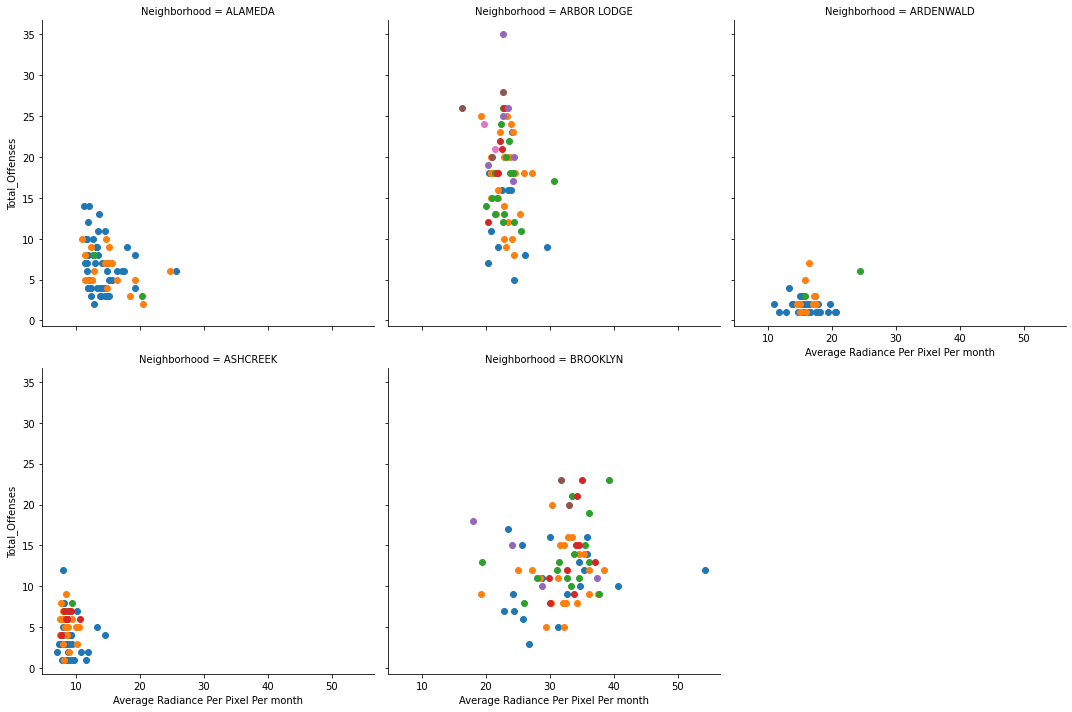

In [35]:
n_month_brightness_crime=pd.read_csv("data/df_with_controls_nighttime.csv")
k= pd.to_datetime(n_month_brightness_crime['OccurMonth_Year'])
n_month_brightness_crime['Year']=k.dt.year
Neighborhoods = ["ALAMEDA","ARBOR LODGE","ARDENWALD","ASHCREEK","BROOKLYN","BROOKLYN"]
n_month_brightness_crime_plot= n_month_brightness_crime[n_month_brightness_crime.Neighborhood.isin(Neighborhoods)]
g = sns.FacetGrid(n_month_brightness_crime_plot, col="Neighborhood",hue='Assault Offenses', height=5,col_wrap=3,)
g.map(plt.scatter, 'Average Radiance Per Pixel Per month', 'Total_Offenses')




In [36]:
corr_df=n_month_brightness_crime[['Bribery', 'Burglary', 'Counterfeiting/Forgery',  'Drug/Narcotic Offenses' ,'Homicide Offenses'
                                  ,  'Fraud Offenses', 'Human Trafficking Offenses', 'Kidnapping/Abduction','Prostitution Offenses',
                                      'Vandalism','median_home_price','median_household_income','unemployed_perc',
                                  'Arson','Average Radiance Per Pixel Per month']]

corr =corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Bribery,Burglary,Counterfeiting/Forgery,Drug/Narcotic Offenses,Homicide Offenses,Fraud Offenses,Human Trafficking Offenses,Kidnapping/Abduction,Prostitution Offenses,Vandalism,median_home_price,median_household_income,unemployed_perc,Arson,Average Radiance Per Pixel Per month
Bribery,1.000000,0.006958,0.011887,0.024042,-0.004315,0.042845,-0.001794,0.022738,0.017678,0.030725,-0.019948,-0.029938,0.051649,0.022508,0.043651
Burglary,0.006958,1.000000,0.192457,0.243870,0.098311,0.308574,0.033267,0.108352,0.093617,0.613619,-0.163135,-0.319936,0.238032,0.367282,0.245880
Counterfeiting/Forgery,0.011887,0.192457,1.000000,0.339207,0.075485,0.350453,-0.001355,0.101746,0.112115,0.273196,-0.171974,-0.212373,0.193864,0.077493,0.175700
Drug/Narcotic Offenses,0.024042,0.243870,0.339207,1.000000,0.085872,0.406547,0.032411,0.144952,0.142158,0.378127,-0.273800,-0.295664,0.285811,0.155093,0.359939
Homicide Offenses,-0.004315,0.098311,0.075485,0.085872,1.000000,0.067109,0.007578,0.018202,0.099941,0.147137,-0.087231,-0.096594,0.082973,0.062212,0.065751
Fraud Offenses,0.042845,0.308574,0.350453,0.406547,0.067109,1.000000,0.042980,0.110933,0.173324,0.399715,-0.222811,-0.283374,0.248537,0.159625,0.288690
Human Trafficking Offenses,-0.001794,0.033267,-0.001355,0.032411,0.007578,0.042980,1.000000,0.029232,0.035494,0.043695,-0.036135,-0.037017,0.038311,0.009624,0.011059
Kidnapping/Abduction,0.022738,0.108352,0.101746,0.144952,0.018202,0.110933,0.029232,1.000000,0.034881,0.141902,-0.088946,-0.111469,0.103875,0.052654,0.092988
Prostitution Offenses,0.017678,0.093617,0.112115,0.142158,0.099941,0.173324,0.035494,0.034881,1.000000,0.140985,-0.096313,-0.106853,0.084088,0.036770,0.104732
Vandalism,0.030725,0.613619,0.273196,0.378127,0.147137,0.399715,0.043695,0.141902,0.140985,1.000000,-0.238808,-0.381537,0.381356,0.482603,0.402762


# Part 2: Analysis of Call for Service Data

We now import the call for service data. This allows us to expand our analysis to different variables, including response time at a geo spatial level. The NIJ Real-Time Crime Forecasting dataset consists of 958,499 calls for service records from the Portland Police Bureau (PPB), representing calls to Portland’s 911 system requesting police ssistance from March 1st, 2012 through February 28th, 2017. As shown in
The four categories of crime, which themselves varied in the degree of internal heterogeneity, included burglary (burglary and prowling), sreet crime (ranging from disturbance and threats up to armed robbery and assault with a Firearm), theft of auto, and all calls for service

This allows us to apply both forecasting models as well as Optimal rotational grid PAI maximizing methodology to predict both crime as well as response rates In particular, we assume a grid of equally sized rectangles and fix the grid vell size to be the minimum allowed in the competition, Amin. We then parametrize the grid with three parameters: cell height h, a grid translation parameter γ and a rotation angle θ. The overall procedure is captured in Algorithm 1.


In [ ]:
df_call_data= pd.read_excel("data/call_for_service_data/excel_sheets_call_for_service/DispatchedCalls_OpenData_2019.xlsx")            
df_call_data =df_call_data [df_call_data ['OpenDataLon'].notnull()]
portland_pol_districs= geopandas.read_file('data/police_districts_portland/Portland_Police_Districts.dbf')
crs = {'init':'EPSG:4326'}
gdf = geopandas.GeoDataFrame(
    df_call_data, crs = crs, geometry=geopandas.points_from_xy(df_call_data['OpenDataLon'], df_call_data['OpenDataLat']))

#### Visualizing the Call for Service Data for Portland based on priority level

In [ ]:
map = folium.Map(location=[ df_call_data.OpenDataLat.mean(),  df_call_data.OpenDataLon.mean()], zoom_start=14, control_scale=True)


#for index, call in df_call_data.iterrows():
    #folium.Marker([call["OpenDataLat"],call["OpenDataLon"]], popup=call["FinalCallCategory"]).add_to(map)
    
map.add_child(FastMarkerCluster(df_call_data[['OpenDataLat', 'OpenDataLon']].values.tolist()))
  

Using more distinct geo-spatial visualization, we can observe crime at the street level,i.e concentrated on certain horitzontal and vertical paths.



import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 6000

In [ ]:
ax = gdf.plot(markersize=.1, figsize=(10,10), cmap='jet')

### Heatmap of Call for Service Locations

THe call for service call seem to be more or less evently districuted with the area around Industrial heights having a lower concentration of call for service.

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
gdf_kd=gdf.head(10000)
sns.kdeplot(x=gdf_kd['OpenDataLon'],y= gdf_kd['OpenDataLat'], shade=True, cmap='viridis');

## Constructing a Rotational Spatial Grid for maximizing accuracy in Crime Forecasts

We construct a grid-like structure over the map, assigning each call and details to each grid.This allows us to construct grid-level predicts for every single grid, and also use the grid-level feature averages to fit a Spatial Random Forest

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
gdf_kd=gdf.head(10000)
sns.kdeplot(x=gdf_kd['OpenDataLon'],y= gdf_kd['OpenDataLat'], shade=True, cmap='viridis');

The procedure $\mathrm{PAI}\left(h, \theta, \gamma, \bar{x}_{i}, t_{i}, \omega, A_{\min }\right)$

a. Set up Grid with cell heigh h,cell area $A_{\min }$, grid angle $\theta$.

b. Calculate event based features on grid using crime locations $\bar{x}_{i}$ and times $t_{i}$.

c. Fit a supervised model M, using tuning parameters w, on event features defined on the training set.

d. Predict M on test data features and output PAI.

In [ ]:

my_geoseries = gdf.set_crs("+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs",allow_override=True)

# total area for the grid
xmin, ymin, xmax, ymax= gdf.total_bounds
# how many cells across and down
n_cells=200
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)       


ax = my_geoseries.plot(markersize=.1, figsize=(20,20), cmap='jet')
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey',figsize=(20,20))
ax.axis("off")

In [ ]:
merged = geopandas.sjoin(my_geoseries, cell, how='left', op='within')
merged['n_crimes']=1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_crimes'] = dissolve.n_crimes.values
merged.to_csv("data/call_service_grid_data.csv", encoding='utf-8', index=False)


#### Visualization of Grid-level call for service levels in Portland City

In [ ]:
ax = cell.plot(column='n_crimes', figsize=(10,10), cmap='viridis', vmax=60, edgecolor="grey")
plt.autoscale(False)
portland_pol_districs.to_crs(epsg=4326).plot(ax=ax, figsize=(10,10), color='none', edgecolor='black')
ax.axis('off')


## GRID level Prediction error minimizing ARIMA Model

### Fitting an ARIMA Forecast on Grid-level Call for Service Data

ARIMA stands for Autoregressive Integrated Moving Average Model. It is a part of a class of models that allow us to predict a time series depending on it's past values. The prerequisite is that the time series be deaseasonalized, and any time series that exhibits patterns and is not random white noise can be modelled with ARIMA models.

**AR model**

An Auto Regressive (AR) model is one where Yt depends only on its own lags.


That is, Yt is a function of the lags of Yt. It is depicted by the following equation -



$Y_{t}=\alpha+\beta_{1} Y_{t-1}+\beta_{2} Y_{t-2}+. .+\beta_{p} Y_{t-p}+\epsilon_{1}$


where,

$Y_{t}$ is the lag1 of the series.


**ARIMA model**

An ARIMA model is one where the time series was differenced at least once to make it stationary and we combine the AR and the MA terms. So the equation of an ARIMA model becomes :




$Y_{t}=\alpha+\beta_{1} Y_{t-1}+\beta_{2} Y_{t-2}+. .+\beta_{p} Y_{t-p} \epsilon_{t}+\phi_{1} \epsilon_{t-1}+\phi_{2} \epsilon_{t-2}+. .+\phi_{q} \epsilon_{t-q}$.





For our purposes we will be using the  AUTO-Arime model my Parima.

Auto-Arima conducts difference tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing,and then fitting models. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing.

**Splitting the data into test and train for purposes of forecasting.**


In [ ]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

merged['Date'] = pd.to_datetime(merged['ReportDateTime']).dt.date
merged_month=merged.groupby(['Date']).n_crimes.sum().reset_index()
merged_month.set_index('Date', inplace=True)
train=merged_month[:300]
test=merged_month[-65:]
plt.plot(train)
plt.plot(test)


A stationary time series is one whose properties do not depend on the time at which the series is observed.14 Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.


In Figure 8.1, note that the Google stock price was non-stationary in panel (a), but the daily changes were stationary in panel (b). This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. There are many different kinds of differencing; for example -


Second-order differencing (or higher)

$\begin{aligned} y_{t}^{\prime \prime} &=y_{t}^{\prime}-y_{t-1}^{\prime} \\ &=\left(y_{t}-y_{t-1}\right)-\left(y_{t-1}-y_{t-2}\right) \\ &=y_{t}-2 y_{t-1}+y_{t-2} . \end{aligned}$



Seasonal differencing

A seasonal difference is the difference between an observation and the previous observation from the same season. So where  
m = the number of seasons.


$y_{t}^{\prime}=y_{t}-y_{t-m}$


These are also called “lag-m differences,” as we subtract the observation after a lag of m periods.



#### Finding the optimum order of differencing:

In [ ]:
merged_month_diff = merged_month
merged_month_diff.index = np.arange(0, len(merged_month))



# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(merged_month_diff.n_crimes); axes[0, 0].set_title('Original Series')
plot_acf(merged_month_diff.n_crimes, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(merged_month_diff.n_crimes.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(merged_month_diff.n_crimes.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(merged_month_diff.n_crimes.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(merged_month_diff.n_crimes.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Fitting a auto-arima model to the crime-call for service data at the grid-level

In [ ]:
model=pm.auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=1, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20,n_fits=50)

#https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0


The model summary allows us to get key determinants of the accuracy of our model.The data inherent in the geo spatial nature of the call of service data is alone not sufficient to provide a accurate forecst. 

In [ ]:
model.summary()

**Plotting prediction vs Test Values**

In [ ]:
prediction = pd.DataFrame(model.predict(n_periods = 65),index=test.index)


prediction.columns = ['predicted_passengers']
plt.figure(figsize=(9,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('SecondPrection.jpg')
plt.show()

**Plotting the model diagnostics**

The “residuals” in a time series model are what is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values:


Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean m,then simply add m to all forecasts and the bias problem is solved.



In [ ]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:

merged_rf=merged.dropna()

from sklearn.model_selection import train_test_split

labels = np.array(merged_rf['ResponseTime_sec'])
features= merged_rf[['TravelTime_sec','Priority','FinalCallGroup','Neighborhood']]
feature_list = list(features.columns)

#features['index_right'] = features.index_right.astype('category')


merged_rf=pd.get_dummies(features)
features = np.array(merged_rf)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)



# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small treetree_small = rf_small.estimators_[5]
# Save the tree as a png image

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small treetree_small = rf_small.estimators_[5]
# Save the tree as a png image
print('Mean Absolute Error:', round(np.mean(errors), 2), 'seconds.')

![title](Figures/small_tree.png)


In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=merged_rf.columns)
feat_importances.nlargest(3).plot(kind='barh',figsize=(5,2))

## 7. Conclusion <a class="anchor" id="conclusion"></a>

Based on the first model, where we looked into the relationship between brightness index and crime occurrence numbers across years and by neighborhoods, the conclusion we arrived at is that though brightness index alone is not the biggest predictor of the number of crime occurrence, the choice of focusing only on the sum of the number of relevant offense occurrences gives 4 times better accuracy in prediction, than when we take the total offenses (all types of offenses happened including the relevant ones that we gauged) as the label for Random Forest Model to predict. 

## 8. References <a class="anchor" id="references"></a>

1. The World Bank. [Open Night Lights](https://github.com/worldbank/OpenNightLights): Collection of tools and training materials for exploring the open Nighttime Lights repository. <br>
2. Hitesh Kumar Reddy ToppiReddy, Bhavna Saini, Ginika Mahajan. (2018). Crime Prediction & Monitoring Framework Based on Spatial Analysis. *Procedia Computer Science*, 132, 696-705. <br>
3. Hongjian Wang, Daniel Kifer, Corina Graif, Zhenhui Li. (2016). Crime Rate Inference with Big Data. *KDD '16: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*,  635–644. <br>
4. Kadziolka Kinga. (2016). Analysis of the Crime rate in Poland in Spatial and Temporal Terms. *Central and Eastern European Journal of Management and Economics (CEEJME)*, 1, 81-96. <br>
5. Saffet Erdogan, Mustafa Yalcin, Mehmet Ali Dereli. (2013). Exploratory spatial analysis of crimes against property in Turkey. *Crime Law and Social Change*, 59, 63–78. <br>
6. Xi Chen, William D. Nordhaus. (2019). VIIRS Nighttime Lights in the Estimation of Cross-Sectional and Time-Series GDP. *Remote Sensing*, 1-11. <br>
7. Feng-Chi Hsu, Kimberly E. Baugh, Tilottama Ghosh, Mikhail Zhizhin, Christopher D. Elvidge. (2015). DMSP-OLS Radiance Calibrated Nighttime Lights Time Series with Intercalibration. *Remote Sensing*, 2, 1855-1876.




---

Notebook by Sona Verdiyeva and Abraham Raju | Find us on GitHub at https://github.com/s6soverd and https://github.com/Abraham-newbie

---